In [ ]:
# Import packages

import numpy as np    
import matplotlib.pyplot as plt       
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from fastai.vision.all import *
set_seed(42, reproducible= True)
source = untar_data(URLs.IMAGENETTE)

In [ ]:
# Load and resize data

# check learning rate decay, improve architecture (recent research papers)

classes = ("Tench", "English Springer", "Cassette Player", "Chain Saw", "Church", "French Horn", "Garbage Truck", "Gas Pump", "Golf Ball", "Parachute")

def load_data():
  train = source/"train"
  val = source/"val"

  train_dataset = ImageFolder(
    train,
    transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4663, 0.4590, 0.4300), (0.2764, 0.2721, 0.2951)),
        transforms.RandomErasing()
    ]))

  val_dataset = ImageFolder(
    val,
    transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128), 
        transforms.ToTensor(),
        transforms.Normalize((0.4663, 0.4590, 0.4300), (0.2764, 0.2721, 0.2951))
    ]))

  train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=32)
  
  return train_dataloader, val_dataloader

In [ ]:
def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data,dim=([0,2,3]))
        squared_sum += torch.mean(data**2, dim=([0,2,3]))
        batches += 1
    mean = sum_/batches
    std = (squared_sum/batches-mean**2)**0.5
    return mean,std

train_dl, test_dl = load_data()
mean, std = get_mean_std(train_dl)
print(mean, std)

tensor([-0.0002,  0.0017,  0.0015]) tensor([0.9574, 0.9580, 0.9581])


In [ ]:
"""
Taken from https://github.com/digantamisra98/Mish/tree/master/Mish/Torch
Applies the mish function element-wise:
mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
"""

class Mish(nn.Module):
    """
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        >>> m = Mish()
        >>> input = torch.randn(2)
        >>> output = m(input)
    Reference: https://pytorch.org/docs/stable/generated/torch.nn.Mish.html
    """

    def __init__(self):
        """
        Init method.
        """
        super().__init__()

    def forward(self, input):
        """
        Forward pass of the function.
        """
        if torch.__version__ >= "1.9":
            return F.mish(input)
        else:
            return input * torch.tanh(F.softplus(input))

In [ ]:
# Define a convolution neural network
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
        
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(12)
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(12)
    self.pool = nn.MaxPool2d(2,2)
    self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(24)
    self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(24)
    self.conv6 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(32)
    self.conv7 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
    self.fc1 = nn.Linear(64*25*25, 128)
    self.fc2 = nn.Linear(128, 10)
  
  def forward(self, input):
    m = Mish()
    output = m(self.bn1(self.conv1(input.cuda())))      
    output = m(self.bn2(self.conv2(output)))     
    output = self.pool(output)                        
    output = m(self.bn4(self.conv4(output)))     
    output = m(self.bn5(self.conv5(output)))     
    output = self.pool(output)
    output = m(self.bn6(self.conv6(output)))
    output = m(self.conv7(output))
    output = output.view(-1, 64*25*25)
    output = m(self.fc1(output))
    output = self.fc2(output)
    output = F.log_softmax(output, dim=1)

    return output

# Instantiate a neural network model 
model = Network()

In [ ]:
from torch.autograd import Variable
from torch.optim import Adam

# Function to save the model
def saveModel():
    path = "./classifier_full.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(device):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def trainAccuracy(device):

    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
 
    # Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    all_accuracy = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 50 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 50 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy for this epoch when tested over all test images
        accuracy = testAccuracy(device)
        train_accuracy = trainAccuracy(device)
        all_accuracy.append(accuracy)
        print('For epoch', epoch+1,'the train accuracy is %d %%' % (train_accuracy), 'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy
    print('The average accuracy over %d' % num_epochs, ' runs is %.2f' % (sum(all_accuracy)/num_epochs))

In [ ]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    if torch.cuda.is_available():
      npimg = img.cpu().numpy()
    else:
      npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch(batch_size):
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ', '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ', '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

def testClassess(batch_size, number_of_labels):
    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            if torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

The model will be running on cuda:0 device
For epoch 1 the train accuracy is 45 % the test accuracy over the whole test set is 45 %
For epoch 2 the train accuracy is 48 % the test accuracy over the whole test set is 49 %
For epoch 3 the train accuracy is 53 % the test accuracy over the whole test set is 53 %
For epoch 4 the train accuracy is 61 % the test accuracy over the whole test set is 60 %
For epoch 5 the train accuracy is 58 % the test accuracy over the whole test set is 60 %
For epoch 6 the train accuracy is 67 % the test accuracy over the whole test set is 66 %
For epoch 7 the train accuracy is 69 % the test accuracy over the whole test set is 67 %
For epoch 8 the train accuracy is 68 % the test accuracy over the whole test set is 65 %
For epoch 9 the train accuracy is 71 % the test accuracy over the whole test set is 68 %
For epoch 10 the train accuracy is 69 % the test accuracy over the whole test set is 68 %
The average accuracy over 10  runs is 60.57
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


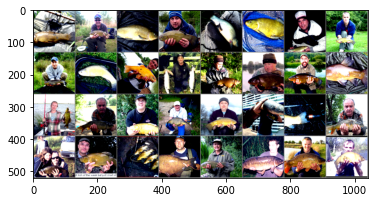

Real labels:  Tench, Tench, Tench, Tench, Tench, Tench, Tench, Tench, Tench, Tench


RuntimeError: ignored

In [ ]:
# Let's build our model
train_loader, test_loader = load_data()

train(10)
print('Finished Training')

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "classifier_full.pth"
model.load_state_dict(torch.load(path))
if torch.cuda.is_available():
  model.cuda()

# Test with batch of images
testBatch(10)

# Test which classes performed well
testClassess(10, 10)